In [17]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt


class LicensePlateDetector:
    def __init__(self, pth_weights: str, pth_cfg: str, pth_classes: str):
        self.net = cv2.dnn.readNet(pth_weights, pth_cfg)
        self.classes = []
        with open(pth_classes, 'r') as f:
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_PLAIN
        self.color = (255, 0, 0)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None
        
#detect a license plate from the input image and draw a rectangle around it        
    def detect(self, img_path: str):
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames()
        layer_outputs = self.net.forward(output_layer_names)
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores) 
                confidence = scores[class_id]
                if confidence > 0.2:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = str(round(confidences[i],2))
                cv2.rectangle(img, (x,y), (x + w, y + h), self.color, 15)
                cv2.putText(img, label + ' ' + confidence, (x, y + 20), self.font, 3, (255, 255, 255), 3)
        self.fig_image = img
        self.coordinates = (x, y, w, h)
        return
    
#Crop the detected license plate from an image to apply some OCR to extract the text    
    def crop_plate(self):
        x, y, w, h = self.coordinates
        roi = self.img[y:y + h, x:x + w]
        self.roi_image = roi
        return

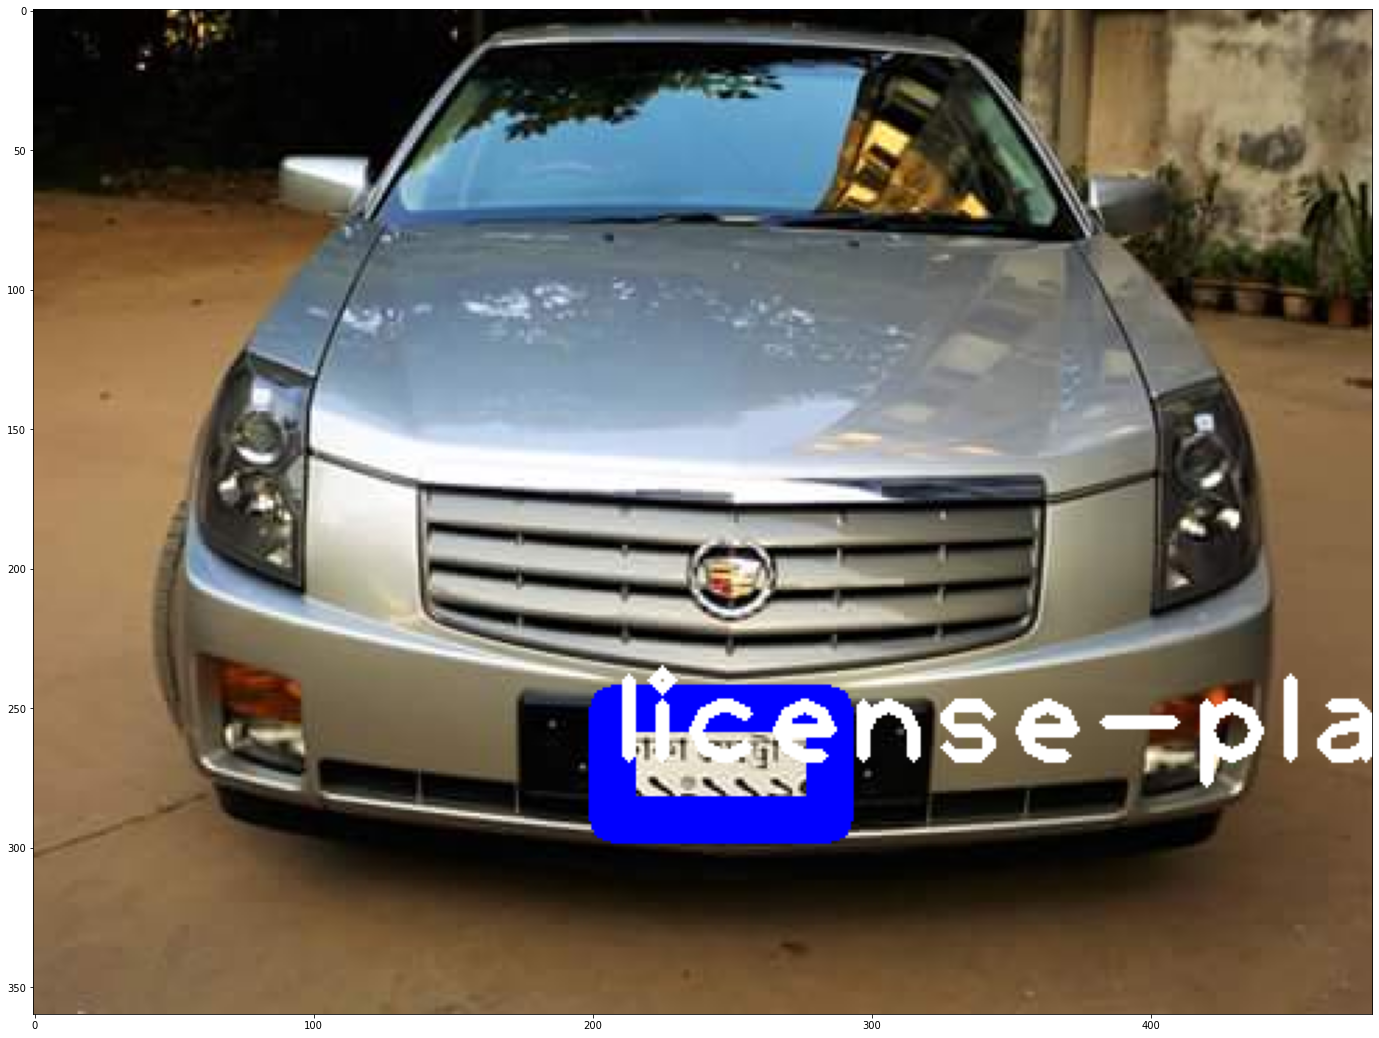

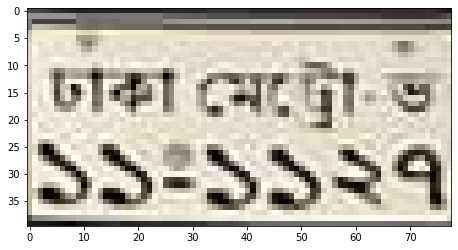

In [18]:
lpd = LicensePlateDetector(
    pth_weights='yolov3-train_final.weights', 
    pth_cfg='yolov3_testing.cfg', 
    pth_classes='classes.txt'
)

# Detect license plate
lpd.detect('64.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(24, 24))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.savefig('detected.jpg')
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB))

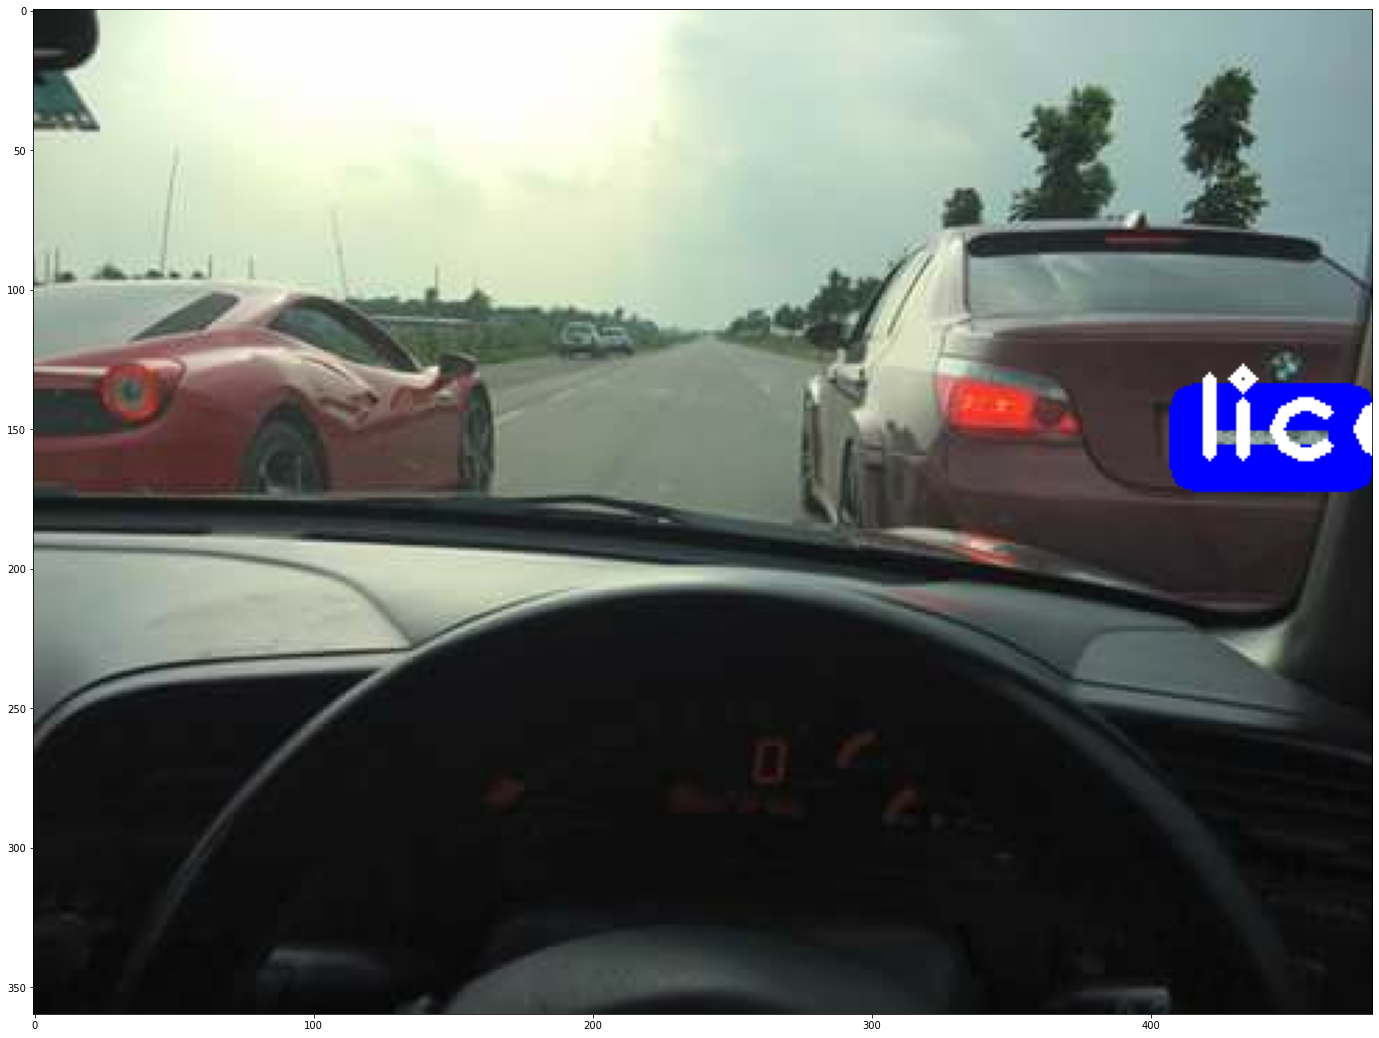

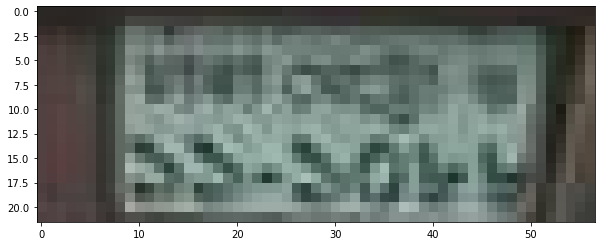

In [19]:
# Detect license plate
lpd.detect('003.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(24, 24))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.savefig('detected.jpg')
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB))

In [20]:
from easyocr import Reader
import cv2

# load the image and resize it
image = cv2.imread('64.jpg')
#image=cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (800, 600))

# convert the input image to grayscale, blur it, and detect the edges 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
blur = cv2.GaussianBlur(gray, (5,5), 0) 
edged = cv2.Canny(blur, 10, 200) 
cv2.imshow('Canny', edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
# find the contours, sort them, and keep only the 5 largest ones
contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in contours:
    # approximate each contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if the contour has 4 points, we can say that we have found our license plate
    if len(approx) == 4:
        n_plate_cnt = approx
        break        

# get the bounding box of the contour & extract the license plate from the image
(x, y, w, h) = cv2.boundingRect(n_plate_cnt)
license_plate = gray[y:y + h, x:x + w]

In [22]:
# initialize the reader object
reader = Reader(['bn'])
# detect the text from the license plate
detection = reader.readtext(license_plate)

if len(detection) == 0:
    # if the text couldn't be read, show a custom message
    text = "Impossible to read the text from the license plate"
    cv2.putText(image, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 3)
    cv2.imshow('Image', image)
    cv2.waitKey(0)
else:
    # draw the contour and write the detected text on the image
    cv2.drawContours(image, [n_plate_cnt], -1, (0, 255, 0), 3)
    text = f"{detection[0][1]} {detection[0][2] * 100:.2f}%"
    cv2.putText(image, text, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    # display the license plate and the output image
    cv2.imshow('license plate', license_plate)
    cv2.imshow('Image', image)
    cv2.waitKey(0)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
